
# Business Cases with Data Science 

## Case 2: Market Basket Analysis

#### Semester: Spring 2020
#### Group (Palm & Company) Member:
1. Pedro Santos (M20190420)
2. Ana Claudia Alferes (M20190932)
3. Lennart Dangers (M20190251)
4. Michael Machatschek (M20190054)

#### This project follows the CRISP-DM Process:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Evaluation
6. Deployment

This jupypter-notebook provides the code in python to do a market basket analysis of a given dataset. A more detailed description of this project and the solutions can be found in the report. 

# Business Understanding

Please consult our report for further details. 

# Data Understanding

## Dataset Description

A data dictionary is available in the appendix of our report.
 
 
 
 #### The following code will help to explore and understand the entire dataset. 

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import plotly.offline as po 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Load and show dataset sample (Chain of Asian Restaurant sales January 2018)
dtypes = {'DocNumber':'category','ProductDesignation':'category'}
df_par = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018_partial.txt",sep=";", dtype=dtypes))
df = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018.txt", sep=";"))

In [3]:
df.head()

DocNumber  ProductDesignation ProductFamily  Qty TotalAmount  \
0  110000012018      SWEETCORN SOUP         SOUPS  2.0       12,00   
1  110000012018         SPRING ROLL      STARTERS  2.0        5,80   
2  110000012018      EGG FRIED RICE          RICE  1.0        6,90   
3  110000012018  SWEET SOUR CHICKEN          MEAT  1.0       12,60   
4  110000012018     LAMB ROGAN JOSH      MAIN IND  1.0       14,60   

           InvoiceDateHour  EmployeeID  IsDelivery  Pax  CustomerID  \
0  2018-01-01 21:47:27.000           2           0    2           0   
1  2018-01-01 21:47:27.000           2           0    2           0   
2  2018-01-01 21:47:27.000           2           0    2           0   
3  2018-01-01 21:47:27.000           2           0    2           0   
4  2018-01-01 21:47:27.000           2           0    2           0   

  CustomerCity CustomerSince  
0          NaN           NaN  
1          NaN           NaN  
2          NaN           NaN  
3          NaN           NaN  
4          NaN           NaN

In [4]:
df.isnull().sum()

DocNumber                 0
ProductDesignation        0
ProductFamily             0
Qty                       0
TotalAmount               0
InvoiceDateHour           0
EmployeeID                0
IsDelivery                0
Pax                       0
CustomerID                0
CustomerCity          52861
CustomerSince         54967
dtype: int64

In [5]:
# Create new Dataframe with orders as rows
agg_func = {"CustomerID":"first", "IsDelivery":"first", "InvoiceDateHour":"first"}
df_orders = df[["DocNumber","CustomerID", "IsDelivery", "InvoiceDateHour"]].groupby("DocNumber").aggregate(agg_func)


In [6]:
# Explore orders/revenue changes between hours/days/months 
df_orders["Day"] =pd.DatetimeIndex(df_orders.InvoiceDateHour).day #most frequent days 
df_orders["Hour"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).hour #most frequent request hours 
df_orders["Month"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).month #most frequent request months 

# Split into restaurant orders and deliveries
df_rest = df_orders[df_orders.IsDelivery == 0] 
df_deli = df_orders[df_orders.IsDelivery == 1] 


fig = make_subplots(3,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Histogram(x=df_rest.Hour,nbinsx=24, name="Restaurant Hour"),1,1)
fig.add_trace(go.Histogram(x=df_deli.Hour,nbinsx=24, name="Delivery Hour"),1,2)

fig.add_trace(go.Histogram(x=df_rest.Day,nbinsx=31, name="Restaurant Day"),2,1)
fig.add_trace(go.Histogram(x=df_deli.Day,nbinsx=31, name="Delivery Day"),2,2)

fig.add_trace(go.Histogram(x=df_rest.Month,nbinsx=12, name="Restaurant Month"),3,1)
fig.add_trace(go.Histogram(x=df_deli.Month,nbinsx=12, name="Delivery Month"),3,2)

fig.update_xaxes(title_text="Hour", row=1, col=1)
fig.update_xaxes(title_text="Hour", row=1, col=2)

fig.update_xaxes(title_text="Day", row=2, col=1)
fig.update_xaxes(title_text="Day", row=2, col=2)

fig.update_xaxes(title_text="Month", row=3, col=1)
fig.update_xaxes(title_text="Month", row=3, col=2)


fig.update_layout(title_text="Number of orders over time", plot_bgcolor="white", showlegend=False)


fig.show() 


In [7]:
# Explore ProductFamily

#ProductFamily Consumption in restaurant 
pf_rest= df[df.IsDelivery == 0][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

#ProductFamily Consumption in deliveries excluding delivery charges
pf_deli= df[df.ProductDesignation != "DELIVERY CHARGE"][df.IsDelivery == 1][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

pf_group = pf_rest.merge(pf_deli, left_on= "ProductFamily", right_on="ProductFamily" ) 
 
fig = go.Figure(data=[ 
    go.Bar(name='Restaurant', x=pf_group['ProductFamily'], y=pf_group['Qty_x']), 
    go.Bar(name='Deliveries', x=pf_group['ProductFamily'], y=pf_group['Qty_y']) 
]) 

# Change the bar mode 
fig.update_layout(barmode="group",height=500, width=1000, title_text="Bestselling product families", plot_bgcolor="white")
fig.show() 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [8]:
# Explore best selling products

p_rest= df[df.IsDelivery == 0][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 
p_deli= df[df.IsDelivery == 1][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 


fig = make_subplots(1,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Bar(name='Restaurant', x=p_rest['ProductDesignation'][0:20], y=p_rest["Qty"][0:20]),1,1)
# exclude delivery charge
fig.add_trace(go.Bar(name='Deliveries', x=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]['ProductDesignation'][0:20], y=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]["Qty"][0:20]),1,2)

fig.update_layout(height=500, width=1000, title_text="Bestselling products", showlegend=False, plot_bgcolor="white")

# Change the bar mode 
fig.show() 

In [9]:
# Convert TotalAmount to float 
df.TotalAmount = df.TotalAmount.apply(lambda x: float(x.replace(",", ".")))

In [10]:
x = df[(df.IsDelivery == 0) & (df.Pax < 20)].Pax.values
fig = px.histogram(x=x)
fig.show()

In [11]:
rev_in = df[df.IsDelivery == 0].TotalAmount.sum()
rev_out = df[df.IsDelivery == 1].TotalAmount.sum()

ord_in = len(df[df.IsDelivery == 0].DocNumber.unique())
ord_out = len(df[df.IsDelivery == 1].DocNumber.unique())

colors = ['darkblue', 'mediumturquoise']

fig = make_subplots(1,2, specs=[[{"type":"domain"},{"type":"domain"}]], subplot_titles=["Revenue", "Number of orders"])

fig.add_trace(go.Pie(labels=["Restaurant", "Delivery"], values=[rev_in, rev_out],marker=dict(colors=colors)),1,1)
fig.add_trace(go.Pie(values=[ord_in, ord_out],marker=dict(colors=colors),showlegend=False),1,2)

fig.update_layout(height=600, width=800, title_text="Restaurant vs. Delivery")


fig.show()

In [12]:
on_cust = df_orders[df_orders.IsDelivery == 1]
freq = on_cust.CustomerID.value_counts()
freq_bins = pd.Series(["1" if i == 1 else "2" if i == 2 else "3-10" if i <= 10 else "10+" for i in freq.values])
fig = go.Figure(go.Pie(labels=freq_bins.value_counts().index, values=freq_bins.value_counts().values))

fig.update_layout(height=600, width=800, title_text="Number of visits per customer")

fig.show()

In [13]:
#Avg Spending per Order 
avg_spend_rest = np.mean(df[df.IsDelivery == 0][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 
avg_spend_deli = np.mean(df[df.IsDelivery == 1][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 

  
print("avg restaurant spending: " + str(round(avg_spend_rest[0],2)) +" €" "\n" + "avg delivery spending: " + str(round(avg_spend_deli[0],2))+ " €") 

avg restaurant spending: 96.75 €
avg delivery spending: 45.05 €


## Data Preparation

In [14]:
# Loading external dataset with holiday information
#read holiday dataset; Source: Time and Date AS (https://www.timeanddate.com/holidays/cyprus/2018) 

holiday = pd.read_csv("Holiday.csv") 

#extract Day and Month in both dataframes for merge 
df["Day"] =pd.DatetimeIndex(df.InvoiceDateHour).day 
df["Month"] = pd.DatetimeIndex(df.InvoiceDateHour).month 
holiday["Day"] =pd.DatetimeIndex(holiday.Date).day  
holiday["Month"] = pd.DatetimeIndex(holiday.Date).month 

#merge holiday and df on Day and Month Columns; drop Date column 
df = df.merge(holiday, left_on=["Day","Month"], right_on=["Day","Month"], how='left') 
df.drop(columns="Date", inplace=True) 

#Replace nan with String "No Holiday" because it is just a normal day 
df["Weekday"].fillna('No Holiday', inplace=True) 
df["Name"].fillna('No Holiday', inplace=True) 
df["Type"].fillna('No Holiday', inplace=True) 

In [15]:
# Check the locations 
# Some typos caused duplicates, such as Lakstameia and Lakatameia
df.CustomerCity.value_counts()

EGKOMI              9480
STROBOLOS           6998
LAKATAMEIA          4688
LEYKOSIA            4184
NICOSIA             2081
AGIOS DOMETIOS      1298
AGLANTZIA           1042
DALI                 709
LATSIA               623
STROBOLO              84
TSERI                 62
LAKATAME              52
LAKSTAMEIA            32
SYN. ANTHOYPOLIS      19
GERI                  18
PANO DEYTERA          14
 EGKOMI                6
Name: CustomerCity, dtype: int64

In [16]:
# fix locations
df["CustomerCity"] = df["CustomerCity"].str.replace(" EGKOMI","EGKOMI") 
df["CustomerCity"] = df["CustomerCity"].str.replace("LAKSTAMEIA","LAKATAMEIA") 
df["CustomerCity"][df["CustomerCity"]=="STROBOLO"] = "STROBOLOS"


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df.head()

DocNumber  ProductDesignation ProductFamily  Qty  TotalAmount  \
0  110000012018      SWEETCORN SOUP         SOUPS  2.0         12.0   
1  110000012018         SPRING ROLL      STARTERS  2.0          5.8   
2  110000012018      EGG FRIED RICE          RICE  1.0          6.9   
3  110000012018  SWEET SOUR CHICKEN          MEAT  1.0         12.6   
4  110000012018     LAMB ROGAN JOSH      MAIN IND  1.0         14.6   

           InvoiceDateHour  EmployeeID  IsDelivery  Pax  CustomerID  \
0  2018-01-01 21:47:27.000           2           0    2           0   
1  2018-01-01 21:47:27.000           2           0    2           0   
2  2018-01-01 21:47:27.000           2           0    2           0   
3  2018-01-01 21:47:27.000           2           0    2           0   
4  2018-01-01 21:47:27.000           2           0    2           0   

  CustomerCity CustomerSince  Day  Month Weekday            Name  \
0          NaN           NaN    1      1  Monday  New Year's Day   
1          NaN           NaN    1      1  Monday  New Year's Day   
2          NaN           NaN    1      1  Monday  New Year's Day   
3          NaN           NaN    1      1  Monday  New Year's Day   
4          NaN           NaN    1      1  Monday  New Year's Day   

               Type  
0  National holiday  
1  National holiday  
2  National holiday  
3  National holiday  
4  National holiday

In [18]:
# Create Pivot tables for apriori

# only delivery
pt_deli = pd.pivot_table( df[df.IsDelivery == 1][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).drop("DELIVERY CHARGE",axis=1) 
# only restaurant
pt_rest = pd.pivot_table(df[df.IsDelivery == 0][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
# all
pt_total = pd.pivot_table(df[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 


## Modelling for Restaurants

In [19]:
frequent_itemsets = apriori(pt_rest, min_support=0.05, use_colnames=True) 

rulesConfidence_rest = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_rest.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_rest.head(10)) 

 
rulesLift_rest = association_rules(frequent_itemsets, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_rest.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_rest.head(10) 

                                           antecedents          consequents  \
397  (SPRING ROLL, EGG FRIED RICE, MINERAL WATER 1....  (NOODLES WITH MEAT)   
72                          (EGG FRIED RICE,  NO MEAT)  (NOODLES WITH MEAT)   
91                             (SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
78                     (MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
256            (SPRING ROLL, EGG FRIED RICE,  NO MEAT)  (NOODLES WITH MEAT)   
95                      (SWEET SOUR CHICKEN,  NO MEAT)  (NOODLES WITH MEAT)   
239    (EGG FRIED RICE, MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
262       (SPRING ROLL, MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
275  (TOFFEE BANANA COMPLEMENTARY, MINERAL WATER 1....  (NOODLES WITH MEAT)   
97             (TOFFEE BANANA COMPLEMENTARY,  NO MEAT)  (NOODLES WITH MEAT)   

     antecedent support  consequent support   support  confidence      lift  \
397            0.053972            0.183729  0.0539

antecedents  \
1129    (EGG FRIED RICE, MINERAL WATER 1.5LT,  NO MEAT)   
1144                   (SPRING ROLL, NOODLES WITH MEAT)   
1140                         (EGG FRIED RICE,  NO MEAT)   
1133  (SPRING ROLL, MINERAL WATER 1.5LT, NOODLES WIT...   
709                     (MINERAL WATER 1.5LT,  NO MEAT)   
708                    (SPRING ROLL, NOODLES WITH MEAT)   
1137                    (MINERAL WATER 1.5LT,  NO MEAT)   
1136   (SPRING ROLL, EGG FRIED RICE, NOODLES WITH MEAT)   
694                    (SPRING ROLL, NOODLES WITH MEAT)   
695                          (EGG FRIED RICE,  NO MEAT)   

                                            consequents  antecedent support  \
1129                   (SPRING ROLL, NOODLES WITH MEAT)            0.073714   
1144    (EGG FRIED RICE, MINERAL WATER 1.5LT,  NO MEAT)            0.115587   
1140  (SPRING ROLL, MINERAL WATER 1.5LT, NOODLES WIT...            0.077695   
1133                         (EGG FRIED RICE,  NO MEAT)            0.111606   
709                    (SPRING ROLL, NOODLES WITH MEAT)            0.116701   
708                     (MINERAL WATER 1.5LT,  NO MEAT)            0.115587   
1137   (SPRING ROLL, EGG FRIED RICE, NOODLES WITH MEAT)            0.116701   
1136                    (MINERAL WATER 1.5LT,  NO MEAT)            0.074670   
694                          (EGG FRIED RICE,  NO MEAT)            0.115587   
695                    (SPRING ROLL, NOODLES WITH MEAT)            0.077695   

      consequent support   support  confidence      lift  leverage  conviction  
1129            0.115587  0.053972    0.732181  6.334479  0.045452    3.302285  
1144            0.073714  0.053972    0.466942  6.334479  0.045452    1.737683  
1140            0.111606  0.053972    0.694672  6.224302  0.045301    2.909638  
1133            0.077695  0.053972    0.483595  6.224302  0.045301    1.786011  
709             0.115587  0.083745    0.717599  6.208318  0.070256    3.131763  
708             0.116701  0.083745    0.724518  6.208318  0.070256    3.206375  
1137            0.074670  0.053972    0.462483  6.193722  0.045258    1.721490  
1136            0.116701  0.053972    0.722814  6.193722  0.045258    3.186670  
694             0.077695  0.055564    0.480716  6.187252  0.046584    1.776111  
695             0.115587  0.055564    0.715164  6.187252  0.046584    3.104991

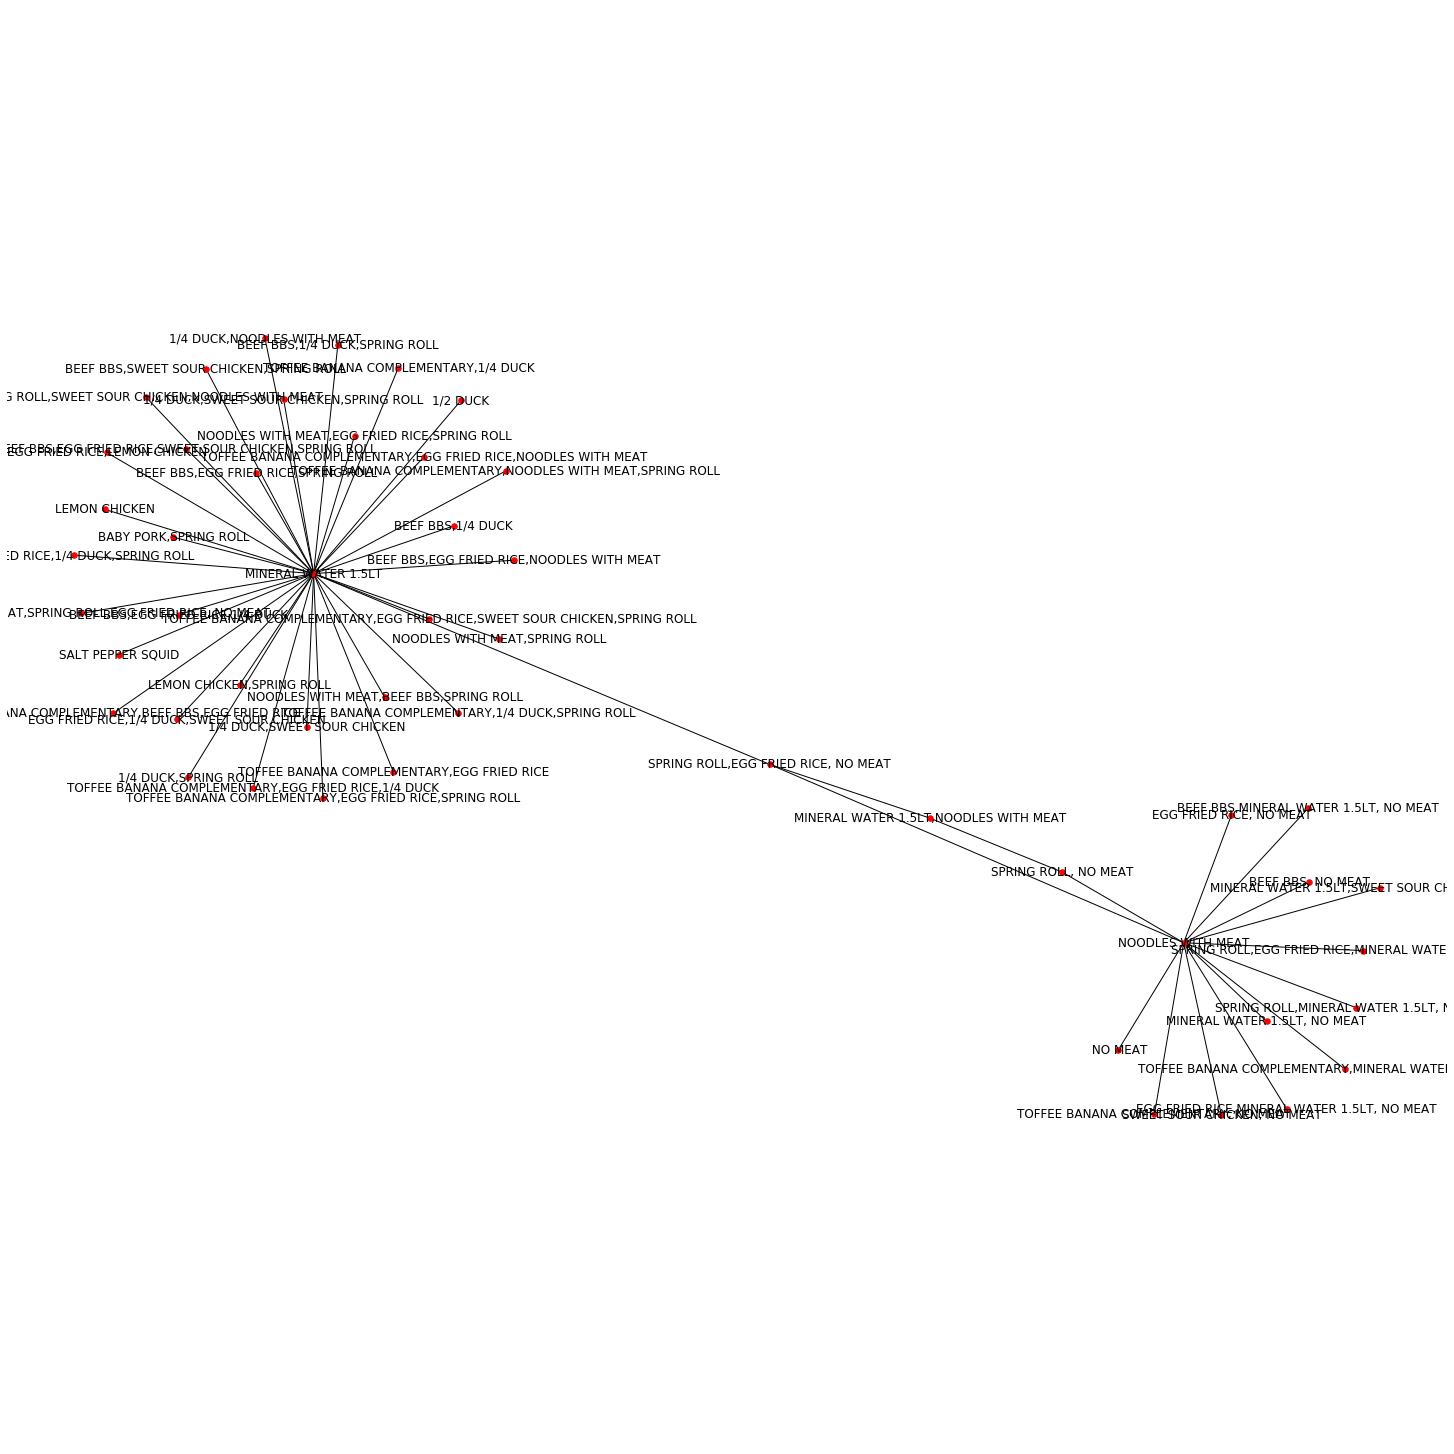

In [20]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 

rulesToPlot_rest = rulesConfidence_rest.copy(deep=True) 

rulesToPlot_rest['LHS'] = [','.join(list(x)) for x in rulesToPlot_rest['antecedents']] 

rulesToPlot_rest['RHS'] = [','.join(list(x)) for x in rulesToPlot_rest['consequents']] 

# Remove duplicate if reversed rules 

rulesToPlot_rest['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_rest.LHS, rulesToPlot_rest.RHS)] 

rulesToPlot_rest['sortedRow'] = rulesToPlot_rest['sortedRow'].astype(str) 

rulesToPlot_rest.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 

rulesToPlot_rest=rulesToPlot_rest[:50] 

fig = plt.figure(figsize=(20, 20))  

G = nx.from_pandas_edgelist(rulesToPlot_rest, 'LHS', 'RHS') 

nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 

plt.axis('equal') 

plt.show() 

### New Product Ideas for Restaurants

In [21]:
#General exploration of high confidence and high lift: 
rulesConfidence_rest[(rulesConfidence_rest['confidence'] >= 0.5) & (rulesConfidence_rest['lift'] >= 4)] 

antecedents  \
397  (SPRING ROLL, EGG FRIED RICE, MINERAL WATER 1....   
72                          (EGG FRIED RICE,  NO MEAT)   
91                             (SPRING ROLL,  NO MEAT)   
78                     (MINERAL WATER 1.5LT,  NO MEAT)   
256            (SPRING ROLL, EGG FRIED RICE,  NO MEAT)   
..                                                 ...   
151                  (MINERAL WATER 1.5LT, JIRA PULAO)   
96                                          ( NO MEAT)   
273                    (MINERAL WATER 1.5LT,  NO MEAT)   
23                                        (JIRA PULAO)   
405  (EGG FRIED RICE, MINERAL WATER 1.5LT, NOODLES ...   

                                 consequents  antecedent support  \
397                      (NOODLES WITH MEAT)            0.053972   
72                       (NOODLES WITH MEAT)            0.077695   
91                       (NOODLES WITH MEAT)            0.087088   
78                       (NOODLES WITH MEAT)            0.116701   
256                      (NOODLES WITH MEAT)            0.055564   
..                                       ...                 ...   
151                     (CHICK TIKKA MASALA)            0.095208   
96   (SWEET SOUR CHICKEN, NOODLES WITH MEAT)            0.123866   
273  (SWEET SOUR CHICKEN, NOODLES WITH MEAT)            0.116701   
23                      (CHICK TIKKA MASALA)            0.105397   
405                  (SPRING ROLL,  NO MEAT)            0.107785   

     consequent support   support  confidence      lift  leverage  conviction  
397            0.183729  0.053972    1.000000  5.442808  0.044056         inf  
72             0.183729  0.077695    1.000000  5.442808  0.063420         inf  
91             0.183729  0.087088    1.000000  5.442808  0.071087         inf  
78             0.183729  0.116701    1.000000  5.442808  0.095260         inf  
256            0.183729  0.055564    1.000000  5.442808  0.045356         inf  
..                  ...       ...         ...       ...       ...         ...  
151            0.090909  0.050151    0.526756  5.794314  0.041496    1.920977  
96             0.096481  0.064958    0.524422  5.435465  0.053007    1.899831  
273            0.096481  0.061137    0.523874  5.429795  0.049877    1.897648  
23             0.090909  0.053654    0.509063  5.599698  0.044072    1.851748  
405            0.087088  0.053972    0.500739  5.749797  0.044585    1.828525  

[71 rows x 9 columns]

Comments about Menus/new products here

### Substitute Products in Restaurants

In [22]:
rulesLift_rest[rulesLift_rest.lift<1]

antecedents            consequents  antecedent support  \
76   (MINERAL WATER 1.5LT)                 (COKE)            0.906544   
77                  (COKE)  (MINERAL WATER 1.5LT)            0.088999   
106  (MINERAL WATER 1.5LT)           (JIRA PULAO)            0.906544   
107           (JIRA PULAO)  (MINERAL WATER 1.5LT)            0.105397   
548  (MINERAL WATER 1.5LT)     (NAAN, JIRA PULAO)            0.906544   
545     (NAAN, JIRA PULAO)  (MINERAL WATER 1.5LT)            0.073555   
118                 (NAAN)  (MINERAL WATER 1.5LT)            0.117816   
119  (MINERAL WATER 1.5LT)                 (NAAN)            0.906544   
111                  (KEO)  (MINERAL WATER 1.5LT)            0.065754   
110  (MINERAL WATER 1.5LT)                  (KEO)            0.906544   

     consequent support   support  confidence      lift  leverage  conviction  
76             0.088999  0.080401    0.088690  0.996531 -0.000280    0.999661  
77             0.906544  0.080401    0.903399  0.996531 -0.000280    0.967447  
106            0.105397  0.095208    0.105023  0.996448 -0.000339    0.999582  
107            0.906544  0.095208    0.903323  0.996448 -0.000339    0.966690  
548            0.073555  0.066391    0.073235  0.995647 -0.000290    0.999655  
545            0.906544  0.066391    0.902597  0.995647 -0.000290    0.959486  
118            0.906544  0.105556    0.895946  0.988310 -0.001249    0.898153  
119            0.117816  0.105556    0.116438  0.988310 -0.001249    0.998441  
111            0.906544  0.058908    0.895884  0.988241 -0.000701    0.897617  
110            0.065754  0.058908    0.064981  0.988241 -0.000701    0.999173

Comments about substitute products here

### Modelling for Deliveries

In [23]:
frequent_itemsets = apriori(pt_deli, min_support=0.05, use_colnames=True) 

rulesConfidence_deli = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_deli.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_deli.head(10)) 

 
rulesLift_deli = association_rules(frequent_itemsets, metric="lift", min_threshold=0) 
rulesLift_deli.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_deli.head(10) 

                          antecedents          consequents  \
2                          ( NO MEAT)  (NOODLES WITH MEAT)   
1                   ( EXTRA PANCAKES)       ( EXTRA SAUCE)   
0                      ( EXTRA SAUCE)    ( EXTRA PANCAKES)   
14     (1/4 DUCK, SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
9                (SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
19       (TSANTA, SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
16  (SPRING ROLL, SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
5                     (LEMON CHICKEN)     (EGG FRIED RICE)   
4                          (BEEF BBS)     (EGG FRIED RICE)   
12            (1/4 DUCK, SPRING ROLL)     (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
2             0.062474            0.125976  0.062474    1.000000  7.938010   
1             0.085491            0.090423  0.063913    0.747596  8.267734   
0             0.090423            0.085491  0.063913    0.706818  8.267734   
14   

antecedents                     consequents  \
0                   ( EXTRA SAUCE)               ( EXTRA PANCAKES)   
1                ( EXTRA PANCAKES)                  ( EXTRA SAUCE)   
2                       ( NO MEAT)             (NOODLES WITH MEAT)   
3              (NOODLES WITH MEAT)                      ( NO MEAT)   
44                          (NAAN)                    (JIRA PULAO)   
45                    (JIRA PULAO)                          (NAAN)   
81            (SWEET SOUR CHICKEN)      (EGG FRIED RICE, 1/4 DUCK)   
76      (EGG FRIED RICE, 1/4 DUCK)            (SWEET SOUR CHICKEN)   
78  (1/4 DUCK, SWEET SOUR CHICKEN)                (EGG FRIED RICE)   
79                (EGG FRIED RICE)  (1/4 DUCK, SWEET SOUR CHICKEN)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.090423            0.085491  0.063913    0.706818  8.267734   
1             0.085491            0.090423  0.063913    0.747596  8.267734   
2             0.062474            0.125976  0.062474    1.000000  7.938010   
3             0.125976            0.062474  0.062474    0.495922  7.938010   
44            0.119400            0.097205  0.052815    0.442341  4.550593   
45            0.097205            0.119400  0.052815    0.543340  4.550593   
81            0.335799            0.126798  0.070695    0.210526  1.660326   
76            0.126798            0.335799  0.070695    0.557536  1.660326   
78            0.105220            0.412659  0.070695    0.671875  1.628159   
79            0.412659            0.105220  0.070695    0.171315  1.628159   

    leverage  conviction  
0   0.056182    3.119255  
1   0.056182    3.603656  
2   0.054604         inf  
3   0.054604    1.859881  
44  0.041209    1.618901  
45  0.041209    1.928351  
81  0.028116    1.106056  
76  0.028116    1.501142  
78  0.027275    1.789991  
79  0.027275    1.079759

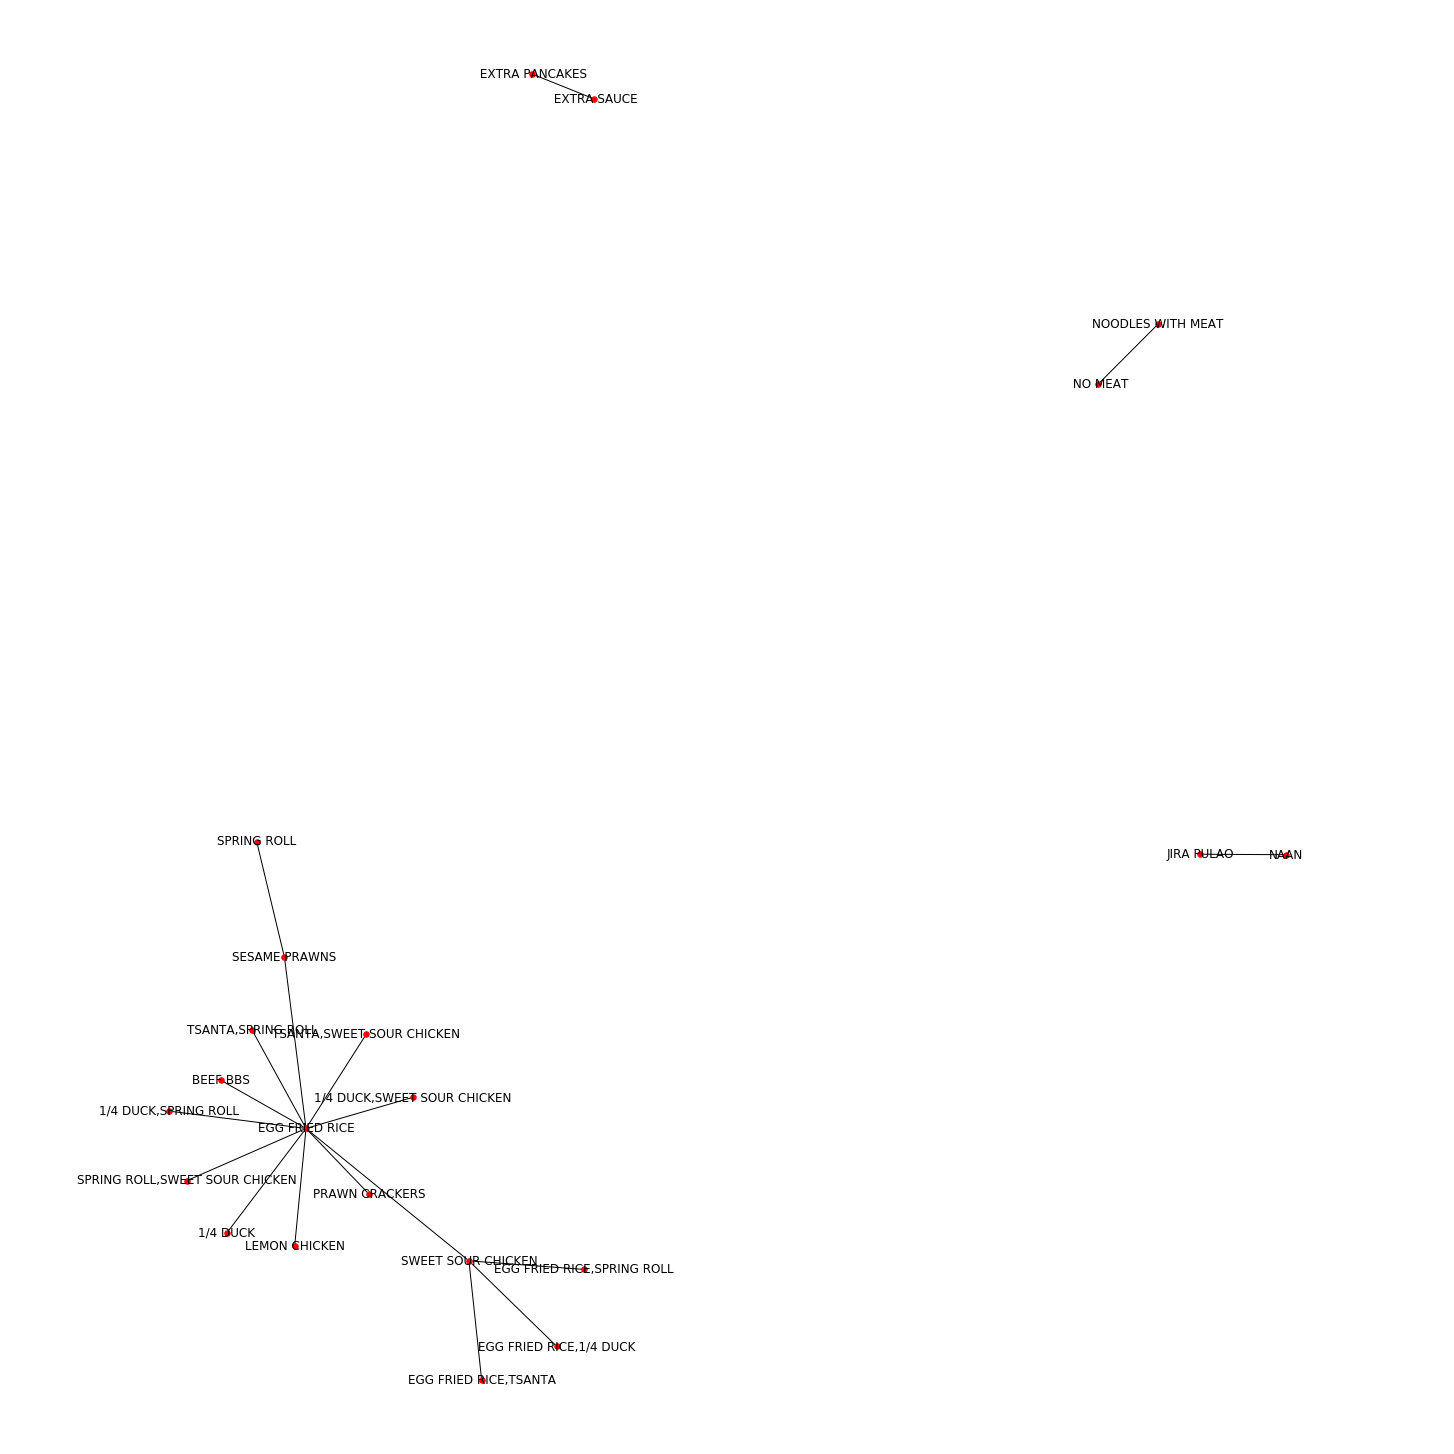

In [24]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 

rulesToPlot_deli = rulesConfidence_deli.copy(deep=True) 

rulesToPlot_deli['LHS'] = [','.join(list(x)) for x in rulesToPlot_deli['antecedents']] 

rulesToPlot_deli['RHS'] = [','.join(list(x)) for x in rulesToPlot_deli['consequents']] 

# Remove duplicate if reversed rules 

rulesToPlot_deli['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_deli.LHS, rulesToPlot_deli.RHS)] 

rulesToPlot_deli['sortedRow'] = rulesToPlot_deli['sortedRow'].astype(str) 

rulesToPlot_deli.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 

rulesToPlot_deli=rulesToPlot_deli[:50] 

fig = plt.figure(figsize=(20, 20))  

G = nx.from_pandas_edgelist(rulesToPlot_deli, 'LHS', 'RHS') 

nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 

plt.axis('equal') 

plt.show() 

### New Product Ideas for Deliveries

In [25]:
#General exploration of high confidence and high lift: 
rulesConfidence_deli[(rulesConfidence_deli['confidence'] >= 0.5) & (rulesConfidence_deli['lift'] >= 4)]

antecedents          consequents  antecedent support  \
2          ( NO MEAT)  (NOODLES WITH MEAT)            0.062474   
1   ( EXTRA PANCAKES)       ( EXTRA SAUCE)            0.085491   
0      ( EXTRA SAUCE)    ( EXTRA PANCAKES)            0.090423   
10       (JIRA PULAO)               (NAAN)            0.097205   

    consequent support   support  confidence      lift  leverage  conviction  
2             0.125976  0.062474    1.000000  7.938010  0.054604         inf  
1             0.090423  0.063913    0.747596  8.267734  0.056182    3.603656  
0             0.085491  0.063913    0.706818  8.267734  0.056182    3.119255  
10            0.119400  0.052815    0.543340  4.550593  0.041209    1.928351

Comments about new products/menus here

### Substitute Products in Deliveries

In [26]:
rulesLift_deli[rulesLift_deli.lift<=1] #No substitute products in Deliveries

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

Comments about substitute products here

### Customer segmentation

In [27]:
# Customer segmmentation 
# Get delivery customers 
df_delicust = df[df.IsDelivery == 1]

# Change dtype to datetime
df_delicust.InvoiceDateHour = pd.to_datetime(df_delicust.InvoiceDateHour, format='%Y-%m-%d %H:%M:%S.%f')

# Mark order as dinner meal if invoice date after 17
df_delicust["Dinner"] = [0 if x.hour < 17 else 1 for x in df_delicust.InvoiceDateHour]
df_delicust.Dinner.value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1    29835
0     1555
Name: Dinner, dtype: int64

In [28]:
# Create df with orders
agg_func = {"DocNumber": "first", "ProductDesignation": lambda x: ",".join(x) , "ProductFamily": lambda x: ",".join(x), 
                          "Qty":"sum", "TotalAmount":"sum", "InvoiceDateHour": "first", "CustomerID": "first", "Dinner": "first"}

deliorders = df_delicust[["DocNumber", "ProductDesignation", "ProductFamily", 
                          "Qty", "TotalAmount", "InvoiceDateHour", "CustomerID", "Dinner"]].groupby("DocNumber").aggregate(agg_func)

deliorders.Dinner.value_counts()

1    4614
0     252
Name: Dinner, dtype: int64

In [29]:
# Create df with customers
agg_func = {"DocNumber": "count", "ProductDesignation": lambda x: ",".join(x) , "ProductFamily": lambda x: ",".join(x), 
                          "Qty":"sum", "TotalAmount":"sum", "InvoiceDateHour": "first", "Dinner": "count"}

delicust = deliorders[["DocNumber", "ProductDesignation", "ProductFamily", 
                          "Qty", "TotalAmount", "InvoiceDateHour", "CustomerID", "Dinner"]].groupby("CustomerID").aggregate(agg_func)
delicust["Lunch"] = delicust["DocNumber"] - delicust["Dinner"]

In [30]:
# Kmeans based on number of vists during dinner and lunch, total spendings and quantity
X_model = delicust[[ "Qty", "TotalAmount", "Dinner", "Lunch"]].copy(deep=True)
# normalize variables 
min_max_scaler = MinMaxScaler() 
X_model_scaled = min_max_scaler.fit_transform(X_model) 
X_model_norm = pd.DataFrame(X_model_scaled, columns=X_model.columns) 


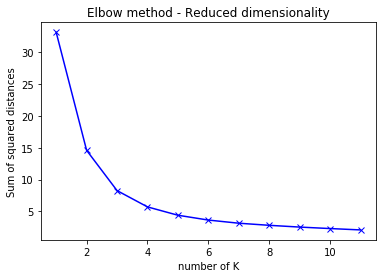

In [31]:
# Select K based on the sum of squared distances 
ssd = [] 

K = range(1,12) 

for k in K: 
    km = KMeans(n_clusters=k, random_state=145) 
    km = km.fit(X_model_norm) 
    ssd.append(km.inertia_) 

# Plot results in an elbow graph 
plt.plot(K, ssd, 'bx-') 
plt.xlabel('number of K') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow method - Reduced dimensionality') 
plt.show() 

In [32]:
# Apply the K-Means for K= 3
K= 3

kmeans = KMeans(n_clusters=K, random_state=145) 

kmeans.fit(X_model_norm) 

y_kmeans = kmeans.predict(X_model_norm) 

X_model["Cluster"]=y_kmeans

In [33]:
X_model.Cluster.value_counts()

0    2029
2     257
1      29
Name: Cluster, dtype: int64